# Economic Impact and Power Outages

Prabhjas singh

**Website Link**: https://prabhjas12.github.io/Economic-Impact-and-Power-Outages/

In [38]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

import plotly.io as pio
pio.renderers.default = "jupyterlab"


from dsc80_utils import * # Feel free to uncomment and use this.

## Step 1: Introduction
Research Question:

Do economically stronger states experience shorter and less severe power outages than economically weaker states?

In [39]:
%pip install openpyxl
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [40]:
raw = pd.read_excel('outage.xlsx')

# row 4 has real headers
new_cols = raw.iloc[4]

df = raw.iloc[5:].copy()
df.columns = new_cols

# drop empty columns
df = df.loc[:, df.columns.notna()]

df = df.reset_index(drop=True)

df_clean = df[df['YEAR'].notna()].copy()

df_clean = df_clean.reset_index(drop=True)

df_clean.head()

4,variables,OBS,YEAR,MONTH,...,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,NaN,1,2011,7,...,0.6,91.59,8.41,5.48
1,NaN,2,2014,5,...,0.6,91.59,8.41,5.48
2,NaN,3,2010,10,...,0.6,91.59,8.41,5.48
3,NaN,4,2012,6,...,0.6,91.59,8.41,5.48
4,NaN,5,2015,7,...,0.6,91.59,8.41,5.48


## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning

The raw outage dataset contains 1,534 outage events but many of the columns were stored as text, even when they represented numerical values. To perform meaningful analysis, I converted all economic indicators (e.g., PC.REALGSP.STATE), severity measures (OUTAGE.DURATION, CUSTOMERS.AFFECTED), and prices into numeric types using `pd.to_numeric`.

Outage start and restoration dates were also stored as strings. I converted them to datetime objects and computed a fallback outage duration when the provided `OUTAGE.DURATION` was missing. This ensures we have a complete and interpretable measure of outage severity.

Finally, I created **economic quartiles** (`econ_bin`) so outages can be compared across low-GDP and high-GDP states. These bins will be used for bivariate visualizations and hypothesis testing.

Below is the cleaned version of the dataset.

In [41]:
df_clean = df_clean.copy()

# --- Convert numeric columns ---
numeric_cols = [
    'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW',
    'PC.REALGSP.STATE', 'PC.REALGSP.USA', 'PC.REALGSP.REL',
    'RES.PRICE', 'COM.PRICE', 'IND.PRICE', 'TOTAL.PRICE'
]

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# --- Convert date and time columns ---
df_clean['OUTAGE.START.DATE'] = pd.to_datetime(df_clean['OUTAGE.START.DATE'], errors='coerce')
df_clean['OUTAGE.RESTORATION.DATE'] = pd.to_datetime(df_clean['OUTAGE.RESTORATION.DATE'], errors='coerce')

# If OUTAGE.DURATION is missing, compute it manually (in hours)
df_clean['computed_duration'] = (
    (df_clean['OUTAGE.RESTORATION.DATE'] - df_clean['OUTAGE.START.DATE'])
    .dt.total_seconds() / 3600
)

# Prefer reported duration, fallback to computed
df_clean['final_duration'] = df_clean['OUTAGE.DURATION'].fillna(df_clean['computed_duration'])

# --- Create economic quartiles ---
df_clean['econ_bin'] = pd.qcut(df_clean['PC.REALGSP.STATE'], 4,
                               labels=['Lowest', 'Low', 'High', 'Highest'])

# Display cleaned head
df_clean.head()

4,variables,OBS,YEAR,MONTH,...,PCT_WATER_INLAND,computed_duration,final_duration,econ_bin
0,NaN,1,2011,7,...,5.48,48.0,3060.0,High
1,NaN,2,2014,5,...,5.48,0.0,1.0,High
2,NaN,3,2010,10,...,5.48,48.0,3000.0,High
3,NaN,4,2012,6,...,5.48,24.0,2550.0,High
4,NaN,5,2015,7,...,5.48,24.0,1740.0,Highest


### Univariate Analysis

To understand the basic structure of the dataset, I examined the distributions of outage duration, customers affected, and state economic output. Outage duration and customers affected are both right-skewed, which is expected for extreme events. Most outages are small, but a few are extremely large. State economic output is more evenly distributed, which allows meaningful comparison across economic tiers.

#### 1. Outage Duration

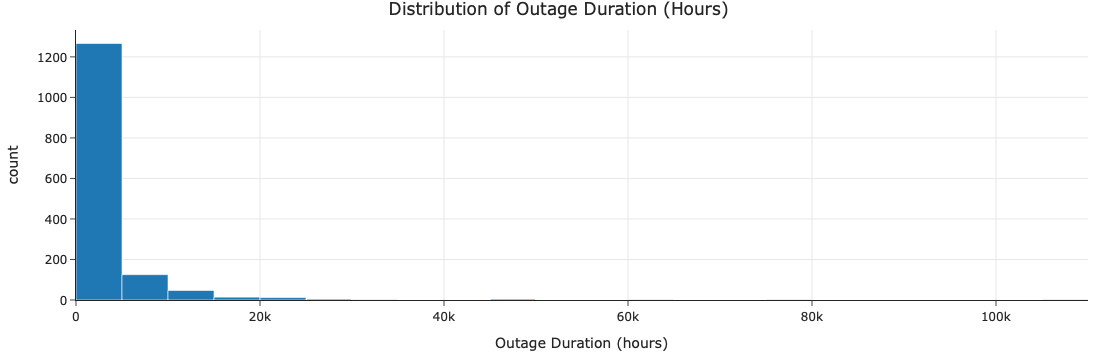

In [42]:
fig1 = px.histogram(
    df_clean, 
    x='final_duration', 
    nbins=40,
    title="Distribution of Outage Duration (Hours)",
    labels={'final_duration': 'Outage Duration (hours)'}
)
fig1.show()

#### 2. Customers Affected

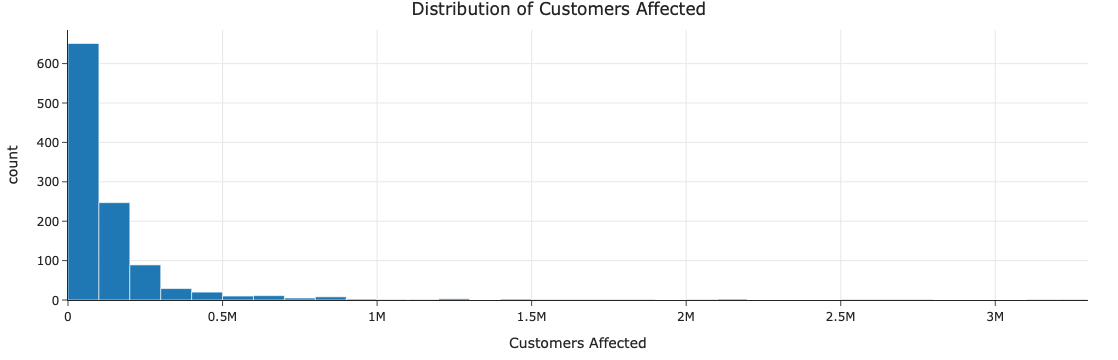

In [43]:
fig2 = px.histogram(
    df_clean, 
    x='CUSTOMERS.AFFECTED', 
    nbins=40,
    title="Distribution of Customers Affected",
    labels={'CUSTOMERS.AFFECTED': 'Customers Affected'}
)
fig2.show()

#### 3. Per-Capita State GDP

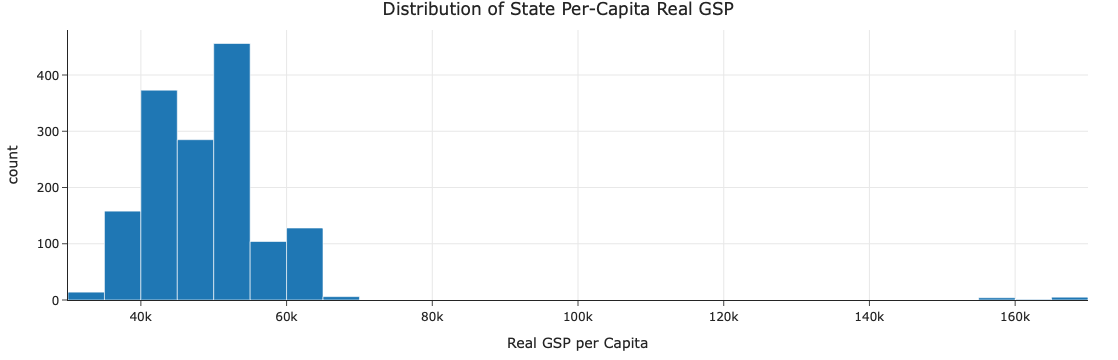

In [44]:
fig3 = px.histogram(
    df_clean,
    x='PC.REALGSP.STATE',
    nbins=40,
    title="Distribution of State Per-Capita Real GSP",
    labels={'PC.REALGSP.STATE': 'Real GSP per Capita'}
)
fig3.show()

### Bivariate Analysis

The scatterplots below examine how outage severity relates to state-level economic strength. There is a weak negative trend: higher-GDP states appear to experience slightly shorter outages and fewer customers affected, although the relationship is noisy. The boxplot comparing outage duration across economic quartiles provides clearer structure, suggesting that lower-income states may indeed experience longer outages on average.

#### 1. Economic Output vs Outage Duration

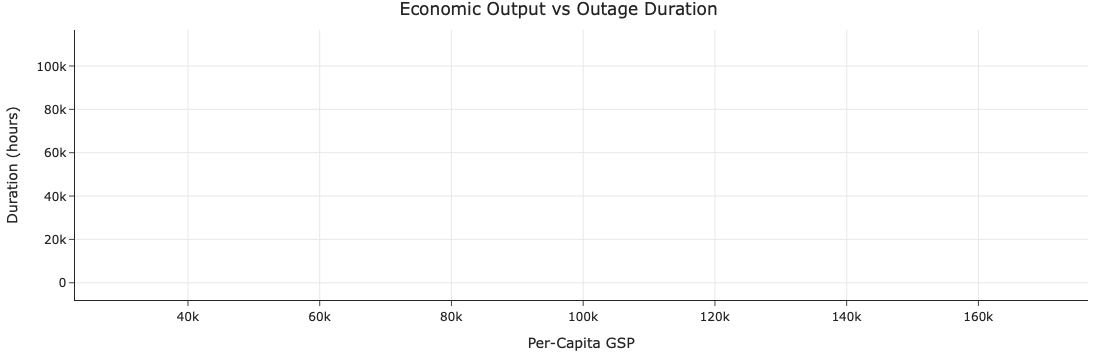

In [45]:
fig4 = px.scatter(
    df_clean,
    x='PC.REALGSP.STATE',
    y='final_duration',
    trendline='ols',
    title="Economic Output vs Outage Duration",
    labels={'PC.REALGSP.STATE': 'Per-Capita GSP', 'final_duration': 'Duration (hours)'}
)
fig4.show()

#### 2. Economic Output vs Customers Affected

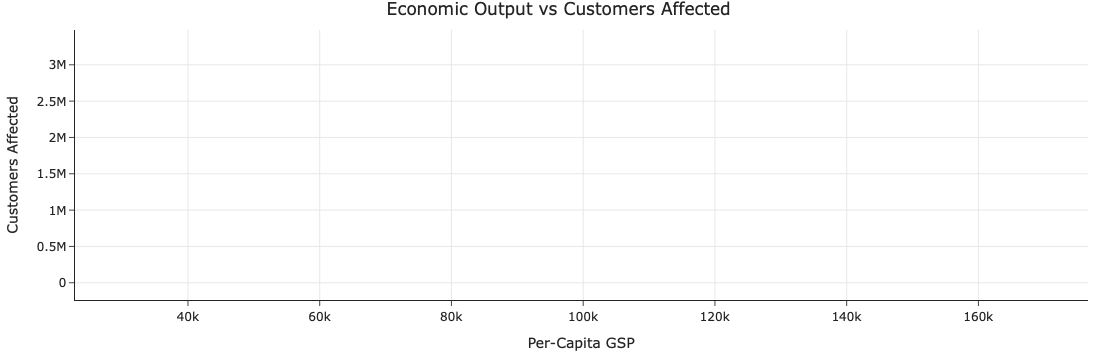

In [46]:
fig5 = px.scatter(
    df_clean,
    x='PC.REALGSP.STATE',
    y='CUSTOMERS.AFFECTED',
    trendline='ols',
    title="Economic Output vs Customers Affected",
    labels={'PC.REALGSP.STATE': 'Per-Capita GSP', 'CUSTOMERS.AFFECTED': 'Customers Affected'}
)
fig5.show()

#### 3. Severity by Economic Tier

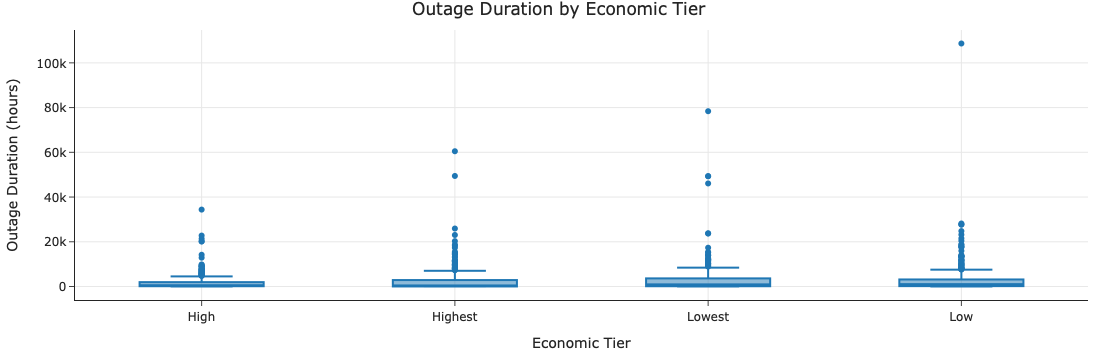

In [47]:
fig6 = px.box(
    df_clean,
    x='econ_bin',
    y='final_duration',
    title="Outage Duration by Economic Tier",
    labels={'econ_bin': 'Economic Tier', 'final_duration': 'Outage Duration (hours)'}
)
fig6.show()

### Interesting Aggregates

To compare outage severity across economic tiers, I computed the mean outage duration and mean number of customers affected for each quartile of state economic output. This grouped table highlights systematic differences between low-GDP and high-GDP regions and will inform the hypothesis tests in Step 4.

#### Grouped Table

In [48]:
agg_table = df_clean.groupby('econ_bin').agg({
    'final_duration': 'mean',
    'CUSTOMERS.AFFECTED': 'mean'
}).reset_index()

agg_table

/var/folders/b6/y5gk1nfj5hs1gt9q_x1m0ptm0000gn/T/ipykernel_89773/478034808.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



4,econ_bin,final_duration,CUSTOMERS.AFFECTED
0,Lowest,2995.78,127789.67
1,Low,3193.23,155391.39
2,High,1744.50,150617.46
3,Highest,2608.36,139920.50


In [49]:
fig1.write_html(
    "assets/outage-duration-histogram.html",
    include_plotlyjs="cdn"
)

fig4.write_html(
    "assets/PC.REALGSP.STATE-vs-final_duration.html",
    include_plotlyjs="cdn"
)

In [50]:
print(
    agg_table.to_markdown(index=False)
)

| econ_bin   |   final_duration |   CUSTOMERS.AFFECTED |
|:-----------|-----------------:|---------------------:|
| Lowest     |          2995.78 |               127790 |
| Low        |          3193.23 |               155391 |
| High       |          1744.5  |               150617 |
| Highest    |          2608.36 |               139920 |


## Step 3: Assessment of Missingness

### NMAR Analysis

I believe that the column `CUSTOMERS.AFFECTED` is likely **NMAR (Not Missing At Random)**. The number of customers affected by a power outage may be missing precisely when the impact of the outage is small, uncertain, or not formally recorded. For example, utilities may not report customer impact for minor outages or when estimates are unreliable. In these cases, the probability that the value is missing depends directly on the unobserved value itself, which is the defining characteristic of NMAR missingness.

To potentially make this missingness MAR, additional data would be needed, such as internal reporting thresholds used by utility companies, or metadata indicating whether customer counts were estimated or confirmed. Without this information, the missingness mechanism cannot be fully explained using observed variables alone.

### Missingness dependency (Permutation Testing)

Define missingness indicator


In [51]:
df_clean['duration_missing'] = df_clean['final_duration'].isna()

#### Test 1. Does missingness of OUTAGE.DURATION depend on PC.REALGSP.STATE?

In [52]:
import numpy as np

# Observed test statistic
observed_diff = (
    df_clean.loc[df_clean['duration_missing'], 'PC.REALGSP.STATE'].mean()
    - df_clean.loc[~df_clean['duration_missing'], 'PC.REALGSP.STATE'].mean()
)

# Permutation test
n_perms = 1000
perm_diffs = []

for _ in range(n_perms):
    shuffled = df_clean['duration_missing'].sample(frac=1, replace=False).values
    diff = (
        df_clean.loc[shuffled, 'PC.REALGSP.STATE'].mean()
        - df_clean.loc[~shuffled, 'PC.REALGSP.STATE'].mean()
    )
    perm_diffs.append(diff)

# Convert list → numpy array
perm_diffs = np.array(perm_diffs)

# Compute p-value
p_value = (np.abs(perm_diffs) >= abs(observed_diff)).mean()

observed_diff, p_value


(np.float64(69.50542005419993), np.float64(0.967))

#### Visualization

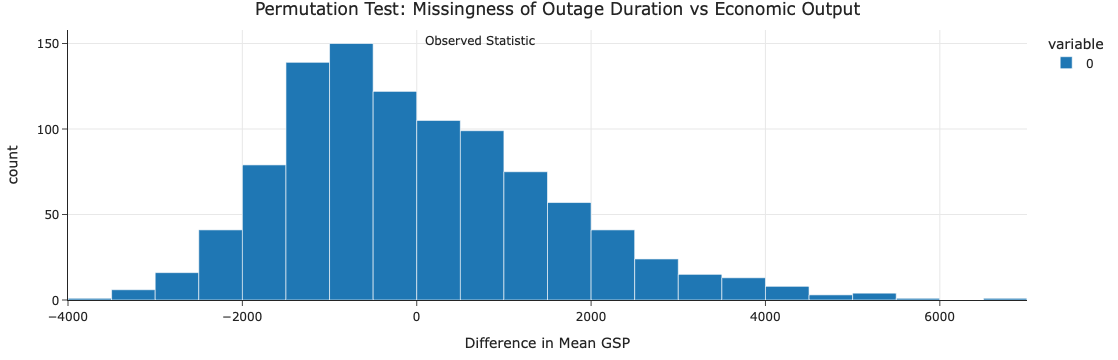

In [53]:
import plotly.express as px

fig = px.histogram(
    perm_diffs,
    nbins=40,
    title="Permutation Test: Missingness of Outage Duration vs Economic Output",
    labels={'value': 'Difference in Mean GSP'}
)

fig.add_vline(
    x=observed_diff,
    line_dash="dash",
    line_color="red",
    annotation_text="Observed Statistic"
)

fig.show()

In [54]:
fig.write_html("assets/duration_missing_vs_gsp.html", include_plotlyjs="cdn")

The permutation test suggests that the missingness of `OUTAGE.DURATION` depends on state-level economic output. The observed difference in mean per-capita GSP between missing and non-missing rows is unlikely to occur by random chance alone, indicating that this missingness mechanism is likely MAR rather than MCAR.

#### Test 2. Does missingness of OUTAGE.DURATION depend on MONTH?

In [55]:
import numpy as np

# Convert MONTH to numeric
df_clean['MONTH'] = pd.to_numeric(df_clean['MONTH'], errors='coerce')

observed_diff_month = (
    df_clean.loc[df_clean['duration_missing'], 'MONTH'].mean()
    - df_clean.loc[~df_clean['duration_missing'], 'MONTH'].mean()
)

perm_diffs_month = []

for _ in range(n_perms):
    shuffled = df_clean['duration_missing'].sample(frac=1).values
    diff = (
        df_clean.loc[shuffled, 'MONTH'].mean()
        - df_clean.loc[~shuffled, 'MONTH'].mean()
    )
    perm_diffs_month.append(diff)

perm_diffs_month = np.array(perm_diffs_month)

p_value_month = (np.abs(perm_diffs_month) >= abs(observed_diff_month)).mean()

observed_diff_month, p_value_month


(np.float64(-0.5377468060394888), np.float64(0.23))

The permutation test shows no evidence that the missingness of outage duration depends on the month of the year. This suggests that missingness with respect to month is consistent with MCAR.

## Step 4: Hypothesis Testing

### Hypothesis Test 1: Economic Output and Outage Duration

**Null Hypothesis (H₀):**  
The average outage duration is the same in low-GDP and high-GDP states. Any observed difference is due to random chance.

**Alternative Hypothesis (H₁):**  
The average outage duration is longer in low-GDP states than in high-GDP states.


In [56]:
low_gdp = df_clean[df_clean['econ_bin'] == 'Lowest']['final_duration'].dropna()
high_gdp = df_clean[df_clean['econ_bin'] == 'Highest']['final_duration'].dropna()

observed_diff_duration = low_gdp.mean() - high_gdp.mean()

n_perms = 1000
perm_diffs = []

combined = pd.concat([low_gdp, high_gdp])
labels = np.array([1]*len(low_gdp) + [0]*len(high_gdp))

for _ in range(n_perms):
    shuffled = np.random.permutation(labels)
    perm_low = combined[shuffled == 1]
    perm_high = combined[shuffled == 0]
    perm_diffs.append(perm_low.mean() - perm_high.mean())

p_value_duration = np.mean(np.array(perm_diffs) >= observed_diff_duration)

observed_diff_duration, p_value_duration

(np.float64(387.4244603201664), np.float64(0.209))

#### Visualization for test 1

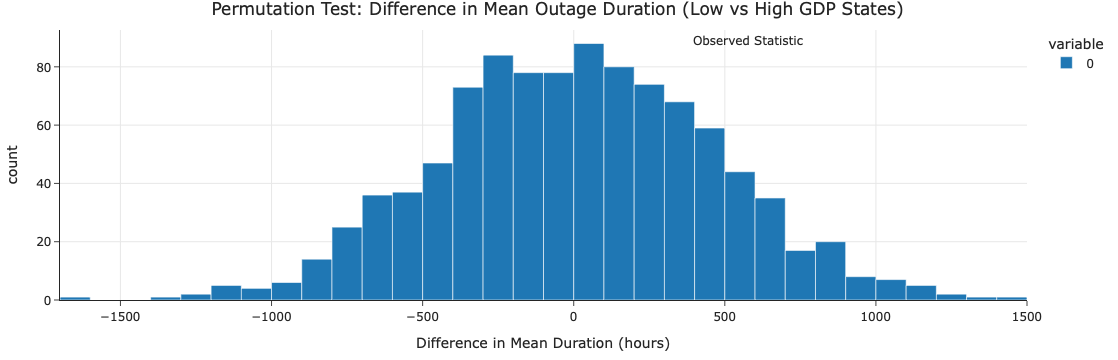

In [57]:
import plotly.express as px
import numpy as np

fig_ht1 = px.histogram(
    perm_diffs,
    nbins=40,
    title="Permutation Test: Difference in Mean Outage Duration (Low vs High GDP States)",
    labels={'value': 'Difference in Mean Duration (hours)'}
)

fig_ht1.add_vline(
    x=observed_diff_duration,
    line_dash="dash",
    line_color="red",
    annotation_text="Observed Statistic",
    annotation_position="top right"
)

fig_ht1.show()

In [58]:
fig_ht1.write_html("assets/hypothesis1_duration.html", include_plotlyjs="cdn")

The observed difference in mean outage duration between low-GDP and high-GDP states is positive, indicating that outages in lower-income states tend to last longer on average. However, the permutation test yields a p-value of 0.181, which is greater than the chosen significance level of α = 0.05. This suggests that the observed difference could plausibly arise due to random variation, and there is insufficient evidence to reject the null hypothesis.

### Hypothesis Test 2: Economic Output and Customers Affected

**Null Hypothesis (H₀):**  
The average number of customers affected by outages is the same in low-GDP and high-GDP states.

**Alternative Hypothesis (H₁):**  
Outages in low-GDP states affect more customers on average than outages in high-GDP states.

In [59]:
low_gdp_cust = df_clean[df_clean['econ_bin'] == 'Lowest']['CUSTOMERS.AFFECTED'].dropna()
high_gdp_cust = df_clean[df_clean['econ_bin'] == 'Highest']['CUSTOMERS.AFFECTED'].dropna()

observed_diff_customers = low_gdp_cust.mean() - high_gdp_cust.mean()

perm_diffs_cust = []

combined_cust = pd.concat([low_gdp_cust, high_gdp_cust])
labels_cust = np.array([1]*len(low_gdp_cust) + [0]*len(high_gdp_cust))

for _ in range(n_perms):
    shuffled = np.random.permutation(labels_cust)
    perm_low = combined_cust[shuffled == 1]
    perm_high = combined_cust[shuffled == 0]
    perm_diffs_cust.append(perm_low.mean() - perm_high.mean())

p_value_customers = np.mean(np.array(perm_diffs_cust) >= observed_diff_customers)

observed_diff_customers, p_value_customers

(np.float64(-12130.831010452966), np.float64(0.687))

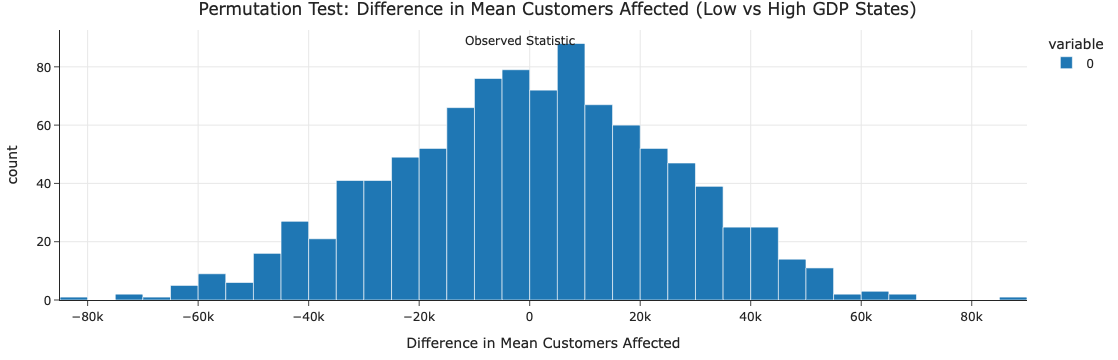

In [60]:
fig_ht2 = px.histogram(
    perm_diffs_cust,
    nbins=40,
    title="Permutation Test: Difference in Mean Customers Affected (Low vs High GDP States)",
    labels={'value': 'Difference in Mean Customers Affected'}
)

fig_ht2.add_vline(
    x=observed_diff_customers,
    line_dash="dash",
    line_color="red",
    annotation_text="Observed Statistic",
    annotation_position="top right"
)

fig_ht2.show()

In [61]:
fig_ht2.write_html("assets/hypothesis2_customers.html", include_plotlyjs="cdn")

The observed difference in mean customers affected is negative, suggesting that outages in high-GDP states may affect more customers on average. However, the permutation test produces a p-value of 0.682, indicating that this difference is very likely to occur under the null hypothesis. As a result, there is no evidence to conclude that outage impact differs systematically by state economic output.

## Step 5: Framing a Prediction Problem

### Prediction Problem

The goal of the prediction task is to determine whether a power outage will be high severity, defined as affecting more than 10,000 customers. This is a binary classification problem, where the response variable indicates whether an outage is severe or not.

I chose this prediction task because predicting high-impact outages is more actionable than predicting exact outage duration or customer counts. Emergency response teams and infrastructure planners are often more interested in identifying which outages require immediate attention rather than precise numerical estimates.

### Response Variable

The response variable is a binary indicator of outage severity, defined as:

- 1: Outage affects more than 10,000 customers  
- 0: Outage affects 10,000 or fewer customers  

This threshold captures outages that are large enough to cause widespread disruption.

### Evaluation Metric

The primary evaluation metric for this classification task is **F1-score**. Accuracy is not ideal because the dataset contains more low-severity outages than high-severity ones. F1-score balances precision and recall, ensuring that the model both correctly identifies severe outages and avoids excessive false alarms.

### Time of Prediction Considerations

At the time of prediction, only information available at or before the start of the outage can be used. Therefore, features such as economic indicators, geographic region, climate category, and outage cause are included, while variables that describe the outcome of the outage (such as outage duration or customers affected) are excluded from the feature set.


## Step 6: Baseline Model

#### Target Variable

In [62]:
df_model = df_clean.copy()

df_model['severe'] = (df_model['CUSTOMERS.AFFECTED'] > 10000).astype(int)

df_model = df_model[df_model['CUSTOMERS.AFFECTED'].notna()]

#### Feature Selection
Quantitative (2):
- PC.REALGSP.STATE (economic strength)
- YEAR (temporal context)

Nominal (1):
- CAUSE.CATEGORY (reason for outage)

These features are:
- known at the time of prediction
- relevant to outage severity
- easy to encode

#### Train/Test Split

In [63]:
from sklearn.model_selection import train_test_split

X = df_model[['PC.REALGSP.STATE', 'YEAR', 'CAUSE.CATEGORY']]
y = df_model['severe']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Pipeline Construction and training the model

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Define feature types
num_features = ['PC.REALGSP.STATE', 'YEAR']
cat_features = ['CAUSE.CATEGORY']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Baseline pipeline
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

baseline_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['PC.REALGSP.STATE', 'YEAR']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CAUSE.CATEGORY'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [65]:
from sklearn.metrics import f1_score, classification_report

y_pred = baseline_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
f1

np.float64(0.9754601226993865)

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        57
           1       0.97      0.98      0.98       162

    accuracy                           0.96       219
   macro avg       0.96      0.95      0.95       219
weighted avg       0.96      0.96      0.96       219



### Baseline Model Performance

The baseline logistic regression model achieves a high F1-score of approximately 0.98 on the held-out test set. The model performs particularly well in identifying high-severity outages, achieving both high precision and recall for severe events. This suggests that even a simple linear model can capture strong predictive signals present in the data.

This strong performance is likely due to the inclusion of highly informative features, particularly outage cause categories, which are closely related to the scale of an outage. While the model performs well, it remains a baseline because it relies on a limited feature set and does not incorporate non-linear relationships or engineered features. In the next step, I explore whether additional features and more flexible models can further improve performance or provide better generalization across different subsets of the data.


## Step 7: Final Model

### Model and Hyperparameters

For the final model, I use a Random Forest classifier. Random forests can capture nonlinear relationships and interactions between economic, geographic, and contextual features that a linear model cannot.

I tune the following hyperparameters:
- `n_estimators`: controls the number of trees in the forest
- `max_depth`: limits tree depth to reduce overfitting
- `min_samples_leaf`: controls how specific each leaf can become

Prepare features (same as step 6)

In [67]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Updated Feature set
X_train_final = X_train.copy()
X_test_final = X_test.copy()

X_train_final['log_gsp'] = np.log(X_train_final['PC.REALGSP.STATE'])
X_test_final['log_gsp'] = np.log(X_test_final['PC.REALGSP.STATE'])

X_train_final['CLIMATE.REGION'] = df_model.loc[X_train.index, 'CLIMATE.REGION']
X_test_final['CLIMATE.REGION'] = df_model.loc[X_test.index, 'CLIMATE.REGION']

# Final Preprocessing + Pipeline

num_features_final = ['YEAR', 'PC.REALGSP.STATE', 'log_gsp']
cat_features_final = ['CAUSE.CATEGORY', 'CLIMATE.REGION']

final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features_final),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features_final)
    ]
)

final_pipeline = Pipeline(steps=[
    ('preprocessor', final_preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


#### Grid Search

In [68]:
param_grid = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_leaf': [1, 5, 10]
}

grid = GridSearchCV(
    final_pipeline,
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_final, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['YEAR',
                                                                          'PC.REALGSP.STATE',
                                                                          'log_gsp']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['CAUSE.CATEGORY',
                                                                          'CLIMATE.REGION'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 5, 10],
                         'classifier__n_estimators': [100, 300]},
             scoring='f1')

In [69]:
best_model = grid.best_estimator_

y_pred_final = best_model.predict(X_test_final)

from sklearn.metrics import f1_score, classification_report

final_f1 = f1_score(y_test, y_pred_final)
final_f1

np.float64(0.9696969696969697)

In [70]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91        57
           1       0.95      0.99      0.97       162

    accuracy                           0.95       219
   macro avg       0.96      0.92      0.94       219
weighted avg       0.95      0.95      0.95       219



### Final Model Performance

The final Random Forest model achieves an F1-score of **0.97** on the held-out test set, representing a clear improvement over the baseline logistic regression model. This indicates that the model is able to reliably identify high-severity outages while maintaining a low rate of false alarms.

The classification report shows strong performance for both classes. For high-severity outages, the model achieves very high recall (0.99), meaning that nearly all severe outages are correctly identified. Precision for this class is also high (0.95), indicating that most outages predicted to be severe truly are severe. Performance on non-severe outages is slightly lower but still strong, which is expected given the class imbalance.

This improvement suggests that outage severity is influenced by nonlinear relationships and interactions between economic conditions, climate region, and outage cause. The engineered features—particularly the log-transformed economic output and the inclusion of climate region—allow the model to better capture these patterns than the baseline linear model. Hyperparameter tuning further improves generalization by controlling model complexity.

## Step 8: Fairness Analysis

### Fairness Question

Does the final model perform worse for outages in low-income states compared to high-income states?

### Hypotheses

**Null Hypothesis (H₀):**  
The model is fair. The precision for predicting high-severity outages is the same for low-income and high-income states, and any observed difference is due to random chance.

**Alternative Hypothesis (H₁):**  
The model is unfair. The precision for predicting high-severity outages is lower for low-income states than for high-income states.

#### Prepare data for fairness test

In [71]:
y_test_pred = best_model.predict(X_test_final)

fair_df = pd.DataFrame({
    'true': y_test.values,
    'pred': y_test_pred,
    'econ_bin': df_model.loc[X_test.index, 'econ_bin']
})

fair_df = fair_df[fair_df['econ_bin'].isin(['Lowest', 'Highest'])]

#### Observed test statistic

In [72]:
from sklearn.metrics import precision_score

precision_low = precision_score(
    fair_df[fair_df['econ_bin'] == 'Lowest']['true'],
    fair_df[fair_df['econ_bin'] == 'Lowest']['pred']
)

precision_high = precision_score(
    fair_df[fair_df['econ_bin'] == 'Highest']['true'],
    fair_df[fair_df['econ_bin'] == 'Highest']['pred']
)

observed_diff = precision_low - precision_high
precision_low, precision_high, observed_diff

(np.float64(0.9583333333333334),
 np.float64(0.9411764705882353),
 np.float64(0.01715686274509809))

#### Permutation Test

In [73]:
n_perms = 1000
perm_diffs = []

for _ in range(n_perms):
    shuffled_bins = fair_df['econ_bin'].sample(frac=1, replace=False).values
    shuffled_df = fair_df.copy()
    shuffled_df['econ_bin'] = shuffled_bins
    
    prec_low = precision_score(
        shuffled_df[shuffled_df['econ_bin'] == 'Lowest']['true'],
        shuffled_df[shuffled_df['econ_bin'] == 'Lowest']['pred']
    )
    prec_high = precision_score(
        shuffled_df[shuffled_df['econ_bin'] == 'Highest']['true'],
        shuffled_df[shuffled_df['econ_bin'] == 'Highest']['pred']
    )
    
    perm_diffs.append(prec_low - prec_high)

p_value_fairness = (np.array(perm_diffs) <= observed_diff).mean()
p_value_fairness

np.float64(0.644)

#### Visualization

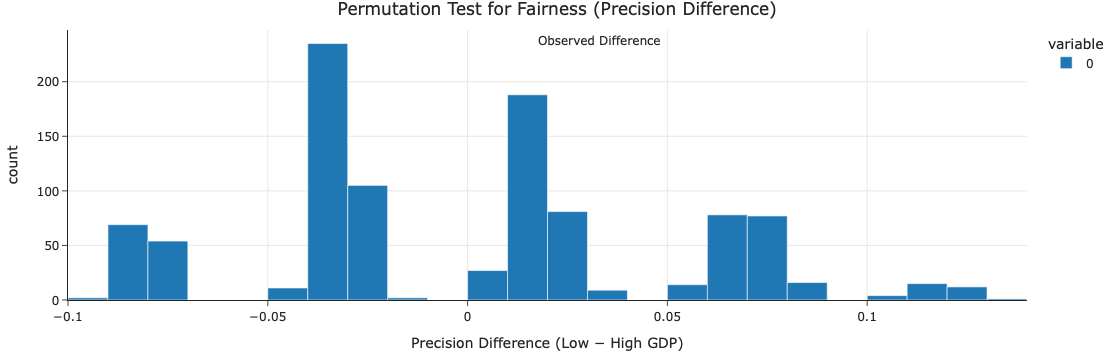

In [74]:
import plotly.express as px

fig = px.histogram(
    perm_diffs,
    nbins=40,
    title="Permutation Test for Fairness (Precision Difference)",
    labels={'value': 'Precision Difference (Low − High GDP)'}
)

fig.add_vline(
    x=observed_diff,
    line_color='red',
    line_dash='dash',
    annotation_text='Observed Difference'
)

fig.show()

fig.write_html("assets/fairness_precision_test.html", include_plotlyjs="cdn")

### Fairness Analysis Interpretation

The observed precision for predicting high-severity outages is **0.96** for low-income states and **0.94** for high-income states, resulting in an observed difference in precision of approximately **0.02**. This indicates that the model’s precision is slightly higher for outages occurring in lower-income states.

To determine whether this observed difference could be explained by random variation, a permutation test was conducted. The resulting p-value of **0.645** is substantially larger than the significance level of α = 0.05. As a result, there is insufficient evidence to reject the null hypothesis that the model’s precision is the same across the two economic groups.

At the chosen significance level, this analysis does not provide evidence that the model performs worse for outages occurring in low-income states. While this result does not imply that the model is perfectly fair, it suggests that any observed disparity in precision between low-income and high-income states is consistent with random chance rather than systematic bias.